<a href="https://colab.research.google.com/github/MuhammetSarican/global_ai_hub-summer_camp/blob/main/Project_2-Transfer_Learning/Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning Projesi Model Eğitimi

Bu kısımda drive bağlantısı yapılmaktadır.

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Bu kısımda gerekli kütüphaneler ve değişkenler oluşturulmaktadır.

---

In [1]:
import os
import cv2
from tensorflow.keras.utils import img_to_array
from matplotlib import pyplot as plt
import numpy as np

data=[]
data_test=[]
label=np.zeros((19958,2))
label_test=np.zeros((4988,2))
resize=150
count=0
count_test=0

Bu kısımda drive bulunan datasetlerin yolu bir değişkene atanmaktadır.

---

In [2]:
dataset_path="/content/drive/MyDrive/Datasets/"

Burada datasetler driveden alınarak değişkenlere atılmaktadır.

---

In [4]:
# X_train=np.load(f"{dataset_path}CatAndDog_X_train_{resize}_29-Aug-2022.npy")
# y_train=np.load(f"{dataset_path}CatAndDog_y_train_{resize}_29-Aug-2022.npy")

# X_test=np.load(f"{dataset_path}CatAndDog_X_test_{resize}_29-Aug-2022.npy")
# y_test=np.load(f"{dataset_path}CatAndDog_y_test_{resize}_29-Aug-2022.npy")

X_val=np.load(f"{dataset_path}CatAndDog_data_validation_{resize}_29-Aug-2022.npy")
y_val=np.load(f"{dataset_path}CatAndDog_label_validation_{resize}_29-Aug-2022.npy")
print(f"""
Train data: {X_train.shape}
Train label: {y_train.shape}

Test data: {X_test.shape}
Test label: {y_test.shape}

Validation data: {X_val.shape}
Validation label: {y_val.shape}
""")




Validation data: (4988, 150, 150, 3)
Validation label: (4988, 2)



Burada ise model eğitimi için gerekli olan kütüphanelerin içe aktarımı yapılmaktadır.


---

In [5]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dense

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import adam_v2 as Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns 
import tensorflow as tf

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

Bu kısım transfer learning için gerekli olan kütüphanelerin içe aktarımı yapılmaktadır.

Transfer learning: Transfer learning bir modelin daha öncesinde doğru parametrelerde eğitilerek belirli ağırlıklara ulaştırılması sağlanır ve bu ağırlıklara sahip model benzer projelerde kullanılarak sıfırdan model oluşturma işleminin önüne geçer.

---

In [7]:
from keras.models import Model
from tensorflow.compat.v1.keras.backend import set_session
from keras.applications import xception

from keras.layers import Input


Burada hazır modelimizi base_model değişkenine atıyoruz.

Not: bu kısımda include_top değişkenini False olarak kullanıyoruz çünkü bizim 2 tane sınıfımız var ve output layerımızı kendimiz oluşturmalıyız.

---

In [8]:
input_tensor=Input(shape=(resize,resize,3))

base_model=tf.keras.applications.EfficientNetB2(
    include_top=False, 
    weights="imagenet",
    input_shape=(resize,resize,3),
    pooling="avg",
 )

Output layer oluşturulur.

---

In [9]:
top_model = Sequential() 
top_model.add(Dense(2, activation = "softmax"))
model=Model(inputs=base_model.input,outputs=top_model(base_model.output))

summary() methodu modelimizin yapısını gösterir.

---

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

Optimizer'ı tanımlıyoruz.

---

In [11]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Modelimizi derliyoruz.

---

In [12]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Bu fonksiyon learning rate'i 5 epochdan sonra kademe olarak azaltmaktadır.

---

In [13]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

Bu kısımda epoch ve batch_size değerlerimizi ayarlıyoruz.

Epoch: Bir öğrenme işleminin kaç sefer tekrarlanacağıdır.
Batch_size: Öğrenme işleminin kaç görselde bir yapılacağıdır, daha da detaylandıracak olursak back-propaganation ve forward-propaganation işlemlerinin kaç görsel ile tekrarlanacağıdır. Epoch/Batch_size işlemi bize step_per_epoch değişkeninin değerini döndürür.

---

In [11]:
epochs = 10 # for better result increase the epochs
batch_size=2

# step_per_epoch=1495
# batch_size = int(X_train.shape[0] /step_per_epoch)
step_per_epoch = int(X_train.shape[0] /batch_size)
print(f"step_per_epoch: {step_per_epoch}")

Datagen işlemi yapay veri oluşturmak için kullanılır. Datasetin yetersiz olduğu durumlarda mevcut datasetindeki resimleri bazı işlemlerden(döndürme, yakınlaştırma, blurlama, vb.) geçirilmesi sonucu dataset arttırma yapılır.

---

In [15]:
# # data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
)

datagen.fit(X_train)

Öğrenme azaltma fonksiyonunu çağırıyoruz.

---

In [16]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Model fit ediyoruz ve eğitimimize başlıyoruz.

---

In [17]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, callbacks=[callback], validation_data = (X_test,y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
7983/7983 [==============================] - 546s 65ms/step - loss: 0.3538 - accuracy: 0.8484 - val_loss: 0.2698 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 2/10
7983/7983 [==============================] - 472s 59ms/step - loss: 0.2260 - accuracy: 0.9094 - val_loss: 0.1615 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 3/10
7983/7983 [==============================] - 469s 59ms/step - loss: 0.1799 - accuracy: 0.9287 - val_loss: 0.1742 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 4/10
7983/7983 [==============================] - 479s 60ms/step - loss: 0.1537 - accuracy: 0.9414 - val_loss: 0.1552 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 5/10
7983/7983 [==============================] - 488s 61ms/step - loss: 0.1257 - accuracy: 0.9513 - val_loss: 0.1611 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 6/10
7983/7983 [==============================] - 483s 60ms/step - loss: 0.1077 - accuracy: 0.9585 - val_loss: 0.1362 - val_accuracy: 0.9491 - lr: 9.0484e-04
Epoch 7/10
7983/7983 [==============

Eğittiğimiz modeli eğitirken kullandığımız veri setlerinden farklı olan ayrı bir veri seti ile test ediyoruz.

---

In [7]:
loss, acc=model.evaluate(X_val,y_val)

156/156 [==============================] - 23s 58ms/step - loss: 0.1039 - accuracy: 0.9599


Modeli ayırt edebilmek ve hangi gün oluşturulduğunu anlamak için sistemden tarihi alan bir değişken oluşturuyoruz.

---

In [8]:
import datetime
date=datetime.datetime.now()
date.strftime("%x")
dateIs=f"{date.day}-{date.strftime('%b')}-{date.year}"
print(dateIs)

29-Aug-2022


Modelin ismini ayırt edici olacak şekilde ayarlıyoruz.

---

In [12]:
modelInfo=f"BatchSize-{batch_size}_ValLoss-{round(loss,2)}_ValAcc-{round(acc,2)}_{dateIs}"
modelInfo

'BatchSize-2_ValLoss-0.1_ValAcc-0.96_29-Aug-2022'

Modelin sonuçlarını matplotlib kütüphanesi ile görselleştiriyoruz.

---

In [ ]:
plt.style.use("ggplot")
plt.figure()
N=epochs

plt.subplot(2,2,1)
plt.title("Training Loss")

plt.plot(np.arange(0,N),history.history["loss"])
plt.subplot(2,2,2)
plt.title("Validation Loss")

plt.plot(np.arange(0,N),history.history["val_loss"])
plt.subplot(2,2,3)
plt.title("Training Accuracy")

plt.plot(np.arange(0,N),history.history["accuracy"])
plt.subplot(2,2,4)
plt.title("Validation Accuracy")

plt.plot(np.arange(0,N),history.history["val_accuracy"])

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Confusion matrix: Confusion bize hangi labelları ne oranda tahmin edebildiğimizi gösterir. Kesişen değerler doğru tahmin sayısını gösterir.

---

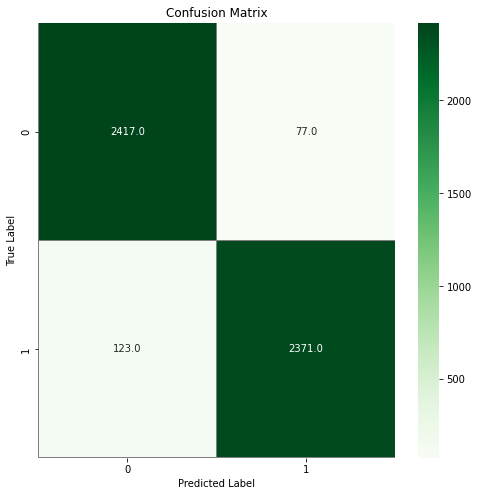

In [13]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Modelimizi kaydediyoruz.

---

In [21]:
print("[INFO] saving network...")
model.save(f"{dataset_path}AI_Summer_Camp-Transfer_Learning_{modelInfo}.model")
print("[INFO] network saved...")

[INFO] saving network...
[INFO] network saved...
